# Primary Stock Forecast Algorithm

### Tensorflow Version Check

In [0]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.2.0


### Imports

In [0]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.style.use('seaborn-poster')

### Reading the Data

In [0]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('ITC.csv')

In [0]:
df.head()

,Unnamed: 0,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,0,09-Apr-2010,EQ,267.80,270.50,265.70,267.75,268.50,269.25,268.64,272.9,177.5,2800852,"752,423,958.40",NaN
1,1,08-Apr-2010,EQ,268.00,268.95,266.35,269.45,266.70,267.75,267.77,272.9,177.5,2086042,"558,576,804.60",NaN
2,2,07-Apr-2010,EQ,265.35,270.00,263.50,266.25,269.45,269.45,266.22,272.9,177.5,2910180,"774,754,436.65",NaN
3,3,06-Apr-2010,EQ,264.80,267.60,263.10,264.80,266.25,266.25,264.99,272.9,177.5,3224970,"854,593,065.00",NaN
4,4,05-Apr-2010,EQ,267.70,268.70,264.10,264.00,264.40,264.80,265.43,272.9,177.5,2445140,"649,016,104.60",NaN


In [0]:
print(df.columns)

Index(['Unnamed: 0', 'Date ', 'series ', 'OPEN ', 'HIGH ', 'LOW ',
       'PREV. CLOSE ', 'ltp ', 'close ', 'vwap ', '52W H ', '52W L ',
       'VOLUME ', 'VALUE ', 'No of trades '],
      dtype='object')


### Cleaning the Data

- Removing Duplicates of Dates
- Sorting by Date

In [0]:
df['Date '] = pd.to_datetime(df['Date '])
df = df.sort_values(by='Date ')
len(df['Date '].unique())
df = df.drop_duplicates(subset='Date ', keep='first')

Simple Time Series Plot to get a general idea of the graph and stock price

In [0]:
time_series = px.line(df ,x='Date ', y='close ')
time_series.show()

## Approach 1: (The Wrong Approach)

In [0]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close '].values.reshape(-1, 1)

In [0]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [0]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 2000
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (966, 2000, 1) Y.shape (966,)


In [0]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
16/16 [==============================] - 2s 99ms/step - loss: 0.1899 - val_loss: 0.1632
Epoch 2/80
16/16 [==============================] - 1s 75ms/step - loss: 0.0401 - val_loss: 0.1420
Epoch 3/80
16/16 [==============================] - 1s 75ms/step - loss: 0.0214 - val_loss: 0.1226
Epoch 4/80
16/16 [==============================] - 1s 75ms/step - loss: 0.0184 - val_loss: 0.1017
Epoch 5/80
16/16 [==============================] - 1s 74ms/step - loss: 0.0174 - val_loss: 0.1034
Epoch 6/80
16/16 [==============================] - 1s 73ms/step - loss: 0.0161 - val_loss: 0.0947
Epoch 7/80
16/16 [==============================] - 1s 74ms/step - loss: 0.0165 - val_loss: 0.0910
Epoch 8/80
16/16 [==============================] - 1s 75ms/step - loss: 0.0161 - val_loss: 0.0985
Epoch 9/80
16/16 [==============================] - 1s 74ms/step - loss: 0.0160 - val_loss: 0.0967
Epoch 10/80
16/16 [==============================] - 1s 74ms/step - loss: 0.0161 - val_loss: 0.0728
Epoch 11/

In [0]:
fig = px.line()
fig.add_scatter(y=r.history['loss'], mode='lines', name='loss')
fig.add_scatter(y=r.history['val_loss'], mode='lines', name='val_loss')
fig.show()

In [0]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]



fig = px.line()
fig.add_scatter(y=Y, name='actual')
fig.add_scatter(y=predictions, name='predictions')
fig.show()
# plt.plot(Y, label='targets')
# plt.plot(predictions, 'ro', label='predictions')
# plt.legend()
# plt.show()

(966, 1)


In [0]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

fig = px.line()
fig.add_scatter(y=validation_target, name='forecast target')
fig.add_scatter(y=validation_predictions, name='forecast predictions')
fig.show()
# plt.plot(validation_target, label='forecast target')
# plt.plot(validation_predictions, label='forecast prediction')
# plt.legend()


**THIS HORRIBLY FAILS ON THE VALIDATION SET**

## Approach 2: LSTM Returns Approach

In [0]:
# calculate returns by first shifting the data
df['PREV. CLOSE'] = df['close '].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [0]:
df.head()

,Unnamed: 0,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades,PREV. CLOSE
484,484,2008-04-11,EQ,207.0,208.35,203.10,206.65,204.65,204.05,205.63,239.4,145.0,3835108,"788,601,974.85",NaN,NaN
483,483,2008-04-15,EQ,203.5,209.50,202.05,204.05,207.90,207.90,206.89,239.4,145.0,5248458,"1,085,851,276.90",NaN,204.05
482,482,2008-04-16,EQ,209.9,210.70,207.20,207.90,210.25,210.00,209.34,239.4,145.0,3836299,"803,086,615.55",NaN,207.90
481,481,2008-04-17,EQ,211.1,212.90,205.10,210.00,211.00,211.45,211.19,239.4,145.0,3087584,"652,072,936.45",NaN,210.00
480,480,2008-04-21,EQ,212.3,215.00,207.45,211.45,208.00,208.20,210.79,239.4,145.0,2518568,"530,899,158.15",NaN,211.45


In [0]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close '] - df['PREV. CLOSE']) / df['PREV. CLOSE']

In [0]:
df.head()

,Unnamed: 0,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades,PREV. CLOSE,Return
484,484,2008-04-11,EQ,207.0,208.35,203.10,206.65,204.65,204.05,205.63,239.4,145.0,3835108,"788,601,974.85",NaN,NaN,NaN
483,483,2008-04-15,EQ,203.5,209.50,202.05,204.05,207.90,207.90,206.89,239.4,145.0,5248458,"1,085,851,276.90",NaN,204.05,0.018868
482,482,2008-04-16,EQ,209.9,210.70,207.20,207.90,210.25,210.00,209.34,239.4,145.0,3836299,"803,086,615.55",NaN,207.90,0.010101
481,481,2008-04-17,EQ,211.1,212.90,205.10,210.00,211.00,211.45,211.19,239.4,145.0,3087584,"652,072,936.45",NaN,210.00,0.006905
480,480,2008-04-21,EQ,212.3,215.00,207.45,211.45,208.00,208.20,210.79,239.4,145.0,2518568,"530,899,158.15",NaN,211.45,-0.015370


In [0]:
# Now let's try an LSTM to predict returns
fig = px.histogram(x=df['Return'])
fig.show()

In [0]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [0]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2955, 10, 1) Y.shape (2955,)


In [0]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
47/47 [==============================] - 1s 11ms/step - loss: 1.0065 - val_loss: 0.7117
Epoch 2/80
47/47 [==============================] - 0s 9ms/step - loss: 0.9996 - val_loss: 0.7060
Epoch 3/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9966 - val_loss: 0.7032
Epoch 4/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9950 - val_loss: 0.7087
Epoch 5/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9942 - val_loss: 0.7240
Epoch 6/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9933 - val_loss: 0.7039
Epoch 7/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9931 - val_loss: 0.7127
Epoch 8/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9914 - val_loss: 0.7078
Epoch 9/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9905 - val_loss: 0.7086
Epoch 10/80
47/47 [==============================] - 0s 5ms/step - loss: 0.9889 - val_loss: 0.7065
Epoch 11/80
47/47 

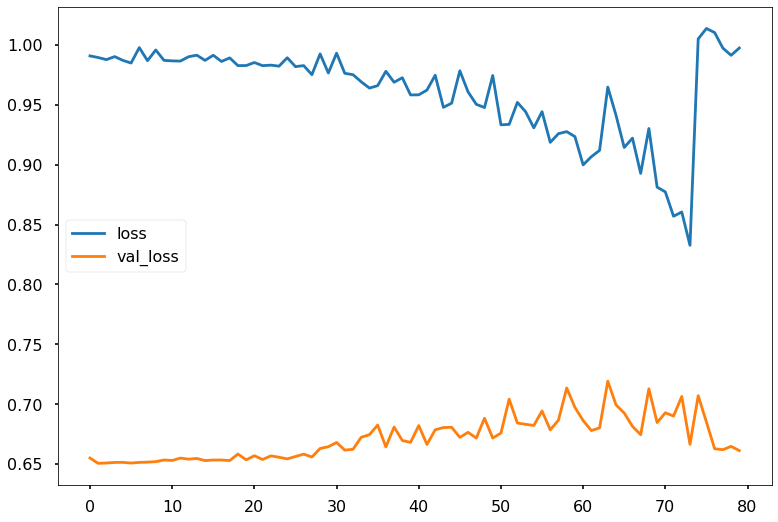

In [0]:
# # Plot loss per iteration
# import matplotlib.pyplot as plt
# plt.plot(r.history['loss'], label='loss')
# plt.plot(r.history['val_loss'], label='val_loss')
# plt.legend()

fig = px.line()
fig.add_scatter(y=r.history['loss'], mode='lines', name='loss')
fig.add_scatter(y=r.history['val_loss'], mode='lines', name='val_loss')
fig.show()

In [0]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

# plt.plot(Y, label='targets')
# plt.plot(predictions, label='predictions')
# plt.legend()
# plt.show()

fig = px.line()
fig.add_scatter(y=Y, name='actual')
fig.add_scatter(y=predictions, name='predictions')
fig.show()


(2955, 1)


In [0]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

# plt.plot(validation_target, label='forecast target')
# plt.plot(validation_predictions, label='forecast prediction')
# plt.legend()


fig = px.line()
fig.add_scatter(y=validation_target, name='forecast target')
fig.add_scatter(y=validation_predictions, name='forecast predictions')
fig.show()

In [0]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['OPEN ', 'HIGH ', 'LOW ', 'close ', 'VOLUME ']].values
targets = df['Return'].values

In [0]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [0]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [0]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [0]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [0]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [0]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=1000, ##CHANGE BACK TO 300 OR LESS
  validation_data=(X_test, Y_test),
)

Epoch 1/1000
62/62 [==============================] - 1s 10ms/step - loss: 0.6953 - accuracy: 0.4891 - val_loss: 0.7005 - val_accuracy: 0.4831
Epoch 2/1000
62/62 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.5144 - val_loss: 0.7089 - val_accuracy: 0.4821
Epoch 3/1000
62/62 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5215 - val_loss: 0.7092 - val_accuracy: 0.4831
Epoch 4/1000
62/62 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5316 - val_loss: 0.7049 - val_accuracy: 0.4842
Epoch 5/1000
62/62 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.5180 - val_loss: 0.7140 - val_accuracy: 0.4821
Epoch 6/1000
62/62 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5296 - val_loss: 0.7115 - val_accuracy: 0.4842
Epoch 7/1000
62/62 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5230 - val_loss: 0.7253 - val_accuracy: 0.4821
Epoch

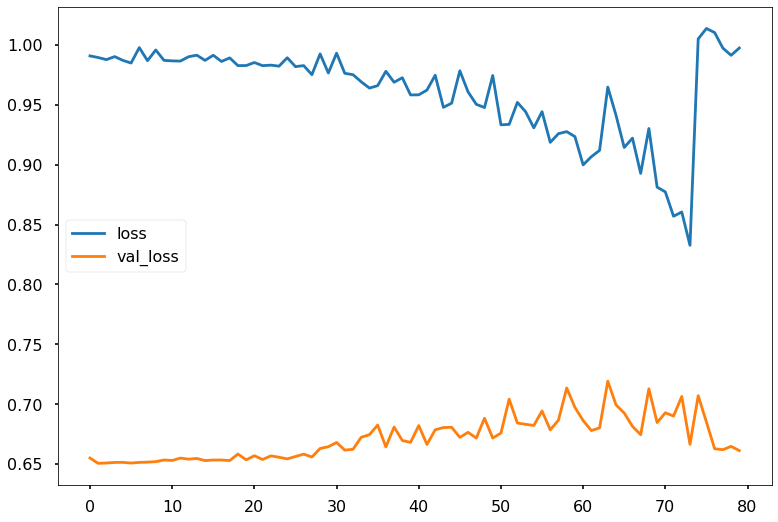

In [0]:
# plot the loss
# plt.plot(r.history['loss'], label='loss')
# plt.plot(r.history['val_loss'], label='val_loss')
# plt.legend()
# plt.show()

fig = px.line()
fig.add_scatter(y=r.history['loss'], mode='lines', name='loss')
fig.add_scatter(y=r.history['val_loss'], mode='lines', name='val_loss')
fig.show()

In [0]:
# Plot accuracy per iteration
# plt.plot(r.history['accuracy'], label='accuracy')
# plt.plot(r.history['val_accuracy'], label='val_accuracy')
# plt.legend()
# plt.show()

fig = px.line()
fig.add_scatter(y=r.history['accuracy'], mode='lines', name='accuracy')
fig.add_scatter(y=r.history['val_accuracy'], mode='lines', name='val_accuracy')
fig.show()

KeyError: 'accuracy'